In [451]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pds
import math
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.simplefilter("ignore")

np.random.seed(1)
random.seed(1)

In [452]:
df = pds.read_csv("all_world_indices_clean.csv")
df_spx = df[["Date", "SPX Index"]]
df_spx["Date"] = pds.to_datetime(df_spx["Date"], format='%d/%m/%Y')
df_spx = df_spx.sort_values(by="Date")
df_spx.reset_index(inplace=True)
series_array = np.array(df_spx["SPX Index"])
log_ret_dat = np.diff(np.log(series_array))
log_ret_dat_stan = (log_ret_dat - np.mean(log_ret_dat)) / np.std(log_ret_dat)

In [453]:
# ============================= NEW ================================= #
def cluster_info(arr):
    """ number of clusters (nonzero fields separated by 0s) in array
        and size of cluster
    """
    data = []
    k2coord = {}
    k = 0

    # =========================================================== #
    tmp_left = 0
    tmp_right = len(arr)-1
    
    if arr[0] != 0 and arr[-1] != 0: # periodic boundaries
        data.append(0)
        k2coord[k] = []
        
        for i in range(0,len(arr)):
            if arr[i] == 0:
                tmp_left = i
                break
            else:
                data[-1] += 1
                k2coord[k].append(i)
                
        if tmp_left != 0:
            for i in range(len(arr)-1,-1,-1):
                if arr[i] == 0:
                    tmp_right = i+1
                    break
                else:
                    data[-1] += 1
                    k2coord[k].append(i)

        for i in range(tmp_left, tmp_right):
            if arr[i] == 0 and arr[i+1] != 0:
                data.append(0)
                k += 1
                k2coord[k] = []
            if arr[i] != 0:
                data[-1] += 1
                k2coord[k].append(i)
    # =========================================================== #              
    else:
        if arr[0] != 0: # left boundary
            data.append(0) # we will increment later in loop  
            k2coord[k] = []
        else:
            k=-1

        # print("arr", arr)
        # print("data", data)

        for i in range(0,len(arr)-1):
            if arr[i] == 0 and arr[i+1] != 0:
                data.append(0)
                k += 1
                k2coord[k] = []
            if arr[i] != 0:
                data[-1] += 1
                k2coord[k].append(i)

        if arr[-1] != 0:
            if data:  # if array is not empty
                data[-1] += 1  # right boundary
                k2coord[k].append(len(arr)-1)
            else:
                data.append(1)  
                k2coord[k] = [len(arr)-1]
        
    Ncl = len(data)  # number of clusters
    Nk = data  # Nk[k] = size of cluster k
    coord2k = {e:k for k,v in k2coord.items() for e in v}
    return Ncl, Nk, k2coord, coord2k
# ============================= NEW ================================= #

def trunc(X, high, low):
    return min(high, max(X, low))

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def visualiseFAST(G, P, N, S, X, D):
    fig, (ax1,ax2) = plt.subplots(ncols=1, nrows=2, figsize=(12,4))
    ax1.imshow(G.T, cmap="bone", interpolation="None", aspect="auto")
    ax2.semilogy(S)
    plt.show()

def visualiseNICE(G, P, N, S, X, D):
    fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(
        ncols=1, nrows=6, figsize=(12,9), sharex=True, gridspec_kw = 
        {'wspace':0, 'hspace':0.05, 'height_ratios':[1,2,1,1,1,1]}
    )
    im1 = ax1.imshow(G.T, cmap="bone", interpolation="None", aspect="auto")
    im4 = ax4.imshow(P.T, cmap="hot", interpolation="None", aspect="auto")
    amnwc = np.max(np.abs(N-initial_account_balance))  # absolute max net worth change
    vmin, vmax = initial_account_balance-amnwc, initial_account_balance+amnwc
    im5 = ax5.imshow(N.T, cmap="bwr", interpolation="None", aspect="auto", vmin=vmin, vmax=vmax)

    size = "15%"

    cax1 = make_axes_locatable(ax1).append_axes('right', size=size, pad=0.05)
    fig.colorbar(im1, cax=cax1, orientation='vertical')
    cax4 = make_axes_locatable(ax4).append_axes('right', size=size, pad=0.05)
    fig.colorbar(im4, cax=cax4, orientation='vertical')
    cax5 = make_axes_locatable(ax5).append_axes('right', size=size, pad=0.05)
    fig.colorbar(im5, cax=cax5, orientation='vertical')

    cax2 = make_axes_locatable(ax2).append_axes('right', size=size, pad=0.05)
    cax2.hist(S, orientation="horizontal", bins=np.linspace(np.min(S), np.max(S), len(S)//2))
    # cax2.hist(np.log10(S), orientation="horizontal", bins=np.logspace(np.log10(np.min(S)), np.log10(np.max(S)), len(S)//2))
    # cax2.set_xscale("log")
    # cax2.set_yscale("log")
    cax2.get_xaxis().set_visible(False)
    cax2.get_yaxis().set_visible(False)

    cax3 = make_axes_locatable(ax3).append_axes('right', size=size, pad=0.05)
    cax3.hist(X, orientation="horizontal", bins=np.linspace(np.min(X), np.max(X), len(X)//5))
    cax3.get_xaxis().set_visible(False)
    cax3.get_yaxis().set_visible(False)

    cax6 = make_axes_locatable(ax6).append_axes('right', size=size, pad=0.05)
    cax6.get_xaxis().set_visible(False)
    cax6.get_yaxis().set_visible(False)

    #ax2.set_yscale("log")
    ax2.plot(S, label="S")
    Ws = [25]
    for W in Ws:
        ax2.plot(np.arange(W-1, len(S)), moving_average(S, W), label=f"MA{W}")
    ax2.grid(alpha=0.4)
    # ax2.legend(ncol=len(Ws)+1)

    ax3.bar(np.arange(len(X)), X)
    ax3.grid(alpha=0.4)

    if D.shape[1] < 25:
        ax6.plot(D, color="black", alpha=0.3)
    ax6.plot(np.mean(D,axis=1), color="black", alpha=1)
    ax6.grid(alpha=0.4)
    

    ax6.set_xlabel("time")
    # ax2.set_ylabel("standardised log returns")
    ax2.set_ylabel("close price")
    ax1.set_ylabel("agents")
    ax3.set_ylabel("log return")
    ax4.set_ylabel("portfolio")
    ax5.set_ylabel("net worth")
    ax6.set_ylabel("influence (I)")

    # fig.colorbar(im, cax=ax4)

    plt.tight_layout()
    plt.show()

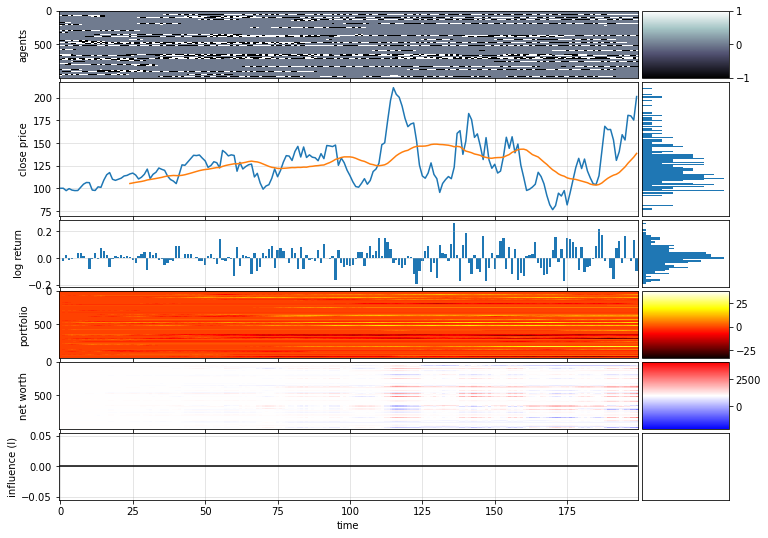

In [454]:
pd = 0.05 # Probability that an active trader diffuses
pe = 0.0001 # Probability that an inactive trader spontaneously enters
ph = 0.0485 # Probability that an active trader turns on 
pa = 0.3 # Initial proportion of active traders

N0 = 200
N1 = 1000

A = 1.8
a = 3.6
h = 1

initial_stock_price = 100

drift = 0
#max_look_back = 3

G = np.zeros(shape=(N0,N1))
G[0] = np.random.choice(a=[-1,0,1], p=[pa/2, 1-pa, pa/2], size=N1, replace=True)
#G[0] = ((np.arange(0,N1)*6//N1)%3)-1
# G[0] = ((np.arange(0,N1)*1//N1)%3)-1

P = np.zeros_like(G) # portfolio: number of stocks
N = np.zeros_like(G) # Net worth
B = np.zeros_like(G) # acc balance

B[0] = initial_account_balance  # everyone start with 1000 money
N[0] = B[0]  # noone has stock initially

D = np.zeros_like(G)

X = np.zeros(N0)
S = np.zeros(N0)
S[0] = initial_stock_price


for t in range(N0-1):
    Ncl, Nk, k2coord, coord2k = cluster_info(G[t])

    Xt = 0
    for k, size in enumerate(Nk):
        tmp = 0
        for i in k2coord[k]:
            tmp += G[t,i]
        Xt += size * tmp
    X[t+1] = Xt/(10*N0)
    S[t+1] = S[t]*math.exp(X[t]) + drift

    xi = np.random.uniform(-1, 1, size=Ncl)  # unique xi for each cluster k

    for i in range(N1):
        P[t+1,i] = P[t,i] + G[t,i]
        # their next balance is their current balance minus
        # their purchase (or sell) of stock at current price
        B[t+1,i] = B[t,i] - (G[t,i] * S[t])
        N[t+1,i] = B[t,i] + (P[t,i]*S[t])

        if G[t,i] != 0:
            # =================================================================

            # original -------------------------------------------------------------------------------
            k = coord2k[i]
            total = 0
            zeta = random.uniform(-1,1)  # sampled for each unique (k,i)
            for j in k2coord[k]:  # for each coordinate in cluster k
                eta = random.uniform(-1,1)  # different for each cell
                sigma = G[t,j]
                cluster_influence = A*xi[k]
                member_influence = a*eta
                total += ((cluster_influence + member_influence) * sigma)
            self_influence = h*zeta
            I = (1 / len(k2coord[k])) * total + self_influence
            p = 1 / (1 + math.exp(-2 * I))


            # =================================================================
            if random.random() < p:
                G[t+1,i] = 1
            else:
                G[t+1,i] = -1

            
        # ==============================================================
        # batolozzi paper dynamics
        
        # trader influences non-active neighbour to join ph
        if G[t,i] != 0:
            stance = G[t,i]
            if random.random() < ph:
                if G[t,(i-1)%N1] == 0 and G[t,(i+1)%N1] == 0:
                    ni = np.random.choice([-1,1])
                    G[t+1,(i+ni)%N1] = np.random.choice([-1,1])
                elif G[t,(i-1)%N1] == 0:
                    G[t+1,(i-1)%N1] = np.random.choice([-1,1])
                elif G[t,(i+1)%N1] == 0:
                    G[t+1,(i+1)%N1] = np.random.choice([-1,1])
                else:
                    continue

        # active trader diffuses if it has inactive neighbour
        # only happens at edge of cluster
        if G[t,i] != 0:
            if random.random() < pd:
                if (G[t,(i-1)%N1] == 0) or (G[t,(i+1)%N1] == 0):
                    G[t+1,i] = 0
                else:
                    continue

        # nontrader enters market
        if G[t,i] == 0:
            if random.random() < pe:
                G[t+1,i] = np.random.choice([-1,1])
        # ==============================================================


final_trade = P[-1] * S[-1]
B[-1] += final_trade
N[-1] = B[-1]

visualiseNICE(G,P,N,S,X,D)
# visualiseFAST(G,P,N,S,X,D)

In [455]:
df = pd.read_csv("all_world_indices_clean.csv")
df_spx = df[["Date", "SPX Index"]]
df_spx["Date"] = pd.to_datetime(df_spx["Date"], format='%d/%m/%Y')
df_spx = df_spx.sort_values(by="Date")
df_spx.reset_index(inplace=True)
series_array = np.array(df_spx["SPX Index"])
log_ret_dat = np.diff(np.log(series_array))
log_ret_dat_stan = (log_ret_dat - np.mean(log_ret_dat)) / np.std(log_ret_dat)

AttributeError: 'float' object has no attribute 'read_csv'

In [ ]:
r = (X - np.mean(X)) / np.std(X)

print(np.std(r))
print(np.std(log_ret_dat_stan))

fig = plt.figure(figsize=(8, 8))
plt.hist(r, alpha=0.4, bins=30, label="CA", density=True)
plt.hist(log_ret_dat_stan, bins=30, alpha=0.4, label="S&P500", density=True)
plt.yscale("log")
plt.title("Log Return Distribution - Standardised")
plt.legend()
plt.grid(alpha=0.2)
plt.show()